In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc

In [65]:
df_data = pd.read_csv('./train.csv')
df_test = pd.read_csv('./test.csv')
b = pd.read_csv('./gender_submission.csv')
test_labels = pd.read_csv('./gender_submission.csv').values[:,1]
train_labels = df_data['Survived']

Age(年龄)、Cabin(船舱号)、Embarked(登船港口)、Fare(船票价格)、Name(姓名)、Parch(不同代直系亲属)、PassengerId(乘客编号)、Pclass(船舱等级)、Sex(性别)、SibSp(同代直系亲属)、survived(生存情况)、Ticket(船票编码)

In [51]:
df_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [52]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [53]:
def deal_age(x):
    if x <= 22:
        return 'Age_low'
    elif x >= 35:
        return 'Age_high'
    else:
        return 'Age_middle'

def deal_fare(x):
    if x <= 8:
        return 'fare_low'
    elif x >= 31:
        return 'fare_high'
    else:
        return 'fare_middle'

def transform(df):  
    df = df[['Pclass','Sex', 'Age', 'Fare', 'Embarked']]
    df = df.fillna(
        value={
            'Age':df['Age'].mean(), 
            'Embarked':df['Embarked'].mode()[0],
            'Fare': df['Fare'].mean()
        }
    )
    df['Age'] = df['Age'].astype('int32')
    df['Age'] = df['Age'].apply(deal_age)
    df['Fare'] = df['Fare'].apply(deal_fare)
    df_dummies_age = pd.get_dummies(df['Age'])
    df_dummies_sex = pd.get_dummies(df['Sex'])
    df_dummies_Embarked = pd.get_dummies(df['Embarked'])
    df_dummies_pclass = pd.get_dummies(df['Pclass'])
    df_dummies_fare = pd.get_dummies(df['Fare'])
    df = pd.concat(
        [df, df_dummies_Embarked, 
         df_dummies_sex, 
         df_dummies_pclass, 
         df_dummies_age, 
         df_dummies_fare,
        ],
        axis=1)
    df.pop('Embarked')
    df.pop('Sex')
    df.pop('Pclass')
    df.pop('Age')
    df.pop('Fare')
    return df

In [54]:
train_features = transform(df_data)

In [55]:
train_features, test_features, train_labels, test_labels = train_test_split(train_features, df_data['Survived'], test_size=0.2, random_state=42,)

In [62]:
# 决策树分类器
params_tree = {
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [x for x in range(2,6)],
    'min_samples_leaf': [x for x in range(1,6)],
}
clf_tree = DecisionTreeClassifier()
clf = GridSearchCV(estimator=clf_tree, param_grid=params_tree, cv=5)
clf.fit(train_features, train_labels)
predict = clf.predict(test_features)
y_score = clf.predict_proba(test_features)[:,1]

In [59]:
# 贝叶斯分类器
params_bayes = {'alpha': [x/100 for x in range(1,101,3)]}
clf_bnb = BernoulliNB()
clf = GridSearchCV(estimator=clf_bnb, param_grid=params_bayes, cv=5)
clf.fit(train_features, train_labels)
predict = clf.predict(test_features)
y_score = clf.predict_proba(test_features)[:,1]

In [63]:
fpr,tpr,threshold = roc_curve(test_labels, y_score)
print('分类器', clf.estimator)
print('最佳参数', clf.best_params_ )
print('准确率', round(accuracy_score(test_labels, predict), 2))
print('精确度', round(precision_score(test_labels, predict), 2))
print('召回率', round(recall_score(test_labels, predict), 2))
print('F1分数', round(f1_score(test_labels, predict), 2))
print('AUC值', round(auc(fpr, tpr),2))

分类器 DecisionTreeClassifier()
最佳参数 {'criterion': 'gini', 'min_samples_leaf': 5, 'min_samples_split': 2}
准确率 0.8
精确度 0.78
召回率 0.72
F1分数 0.75
AUC值 0.86


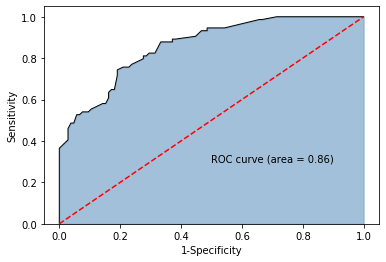

In [61]:
plt.stackplot(fpr, tpr, color='steelblue', alpha = 0.5, edgecolor = 'black')
plt.plot(fpr, tpr, color='black', lw = 1)
plt.plot([0,1],[0,1], color = 'red', linestyle = '--')
plt.text(0.5,0.3,'ROC curve (area = %0.2f)' % round(auc(fpr, tpr),2))
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.show()